In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
booking_df = pd.read_pickle('booking_cleaned.pkl')

In [4]:
booking_df = pd.read_pickle('booking_notNan.pkl')

In [5]:
num_booker = booking_df[booking_df['booker'] == 1].shape[0]
num_non_booker = booking_df[booking_df['booker'] == 0].shape[0]
print(f'There is a total of {num_booker} positive class and {num_non_booker} negative class')
print(f'The ratio of negative:positive is {round(num_non_booker/num_booker, 4)}')

There is a total of 39452 positive class and 111470 negative class
The ratio of negative:positive is 2.8255


In [6]:
booking_df['signup_flow'] = [str(x) for x in booking_df.signup_flow]

#### Let's define our features and targets

In [7]:
booking_df_dummies = pd.get_dummies(booking_df, drop_first = True)

In [8]:
X = booking_df_dummies.drop('booker', 1)
y = booking_df_dummies.booker

#### Train/Test Split

In [9]:
# 60-20-20 train-val-test split (stratify = target for balance positive examples)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

#### Balance out the classes using ADASYN 

In [12]:
from imblearn.over_sampling import ADASYN

X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [11]:
print(f'train set, positive class: {Counter(y_adasyn_train)[0]}, negative class: {Counter(y_adasyn_train)[1]}')

train set, positive class: 66881, negative class: 69685


#### Balance out the classes using SMOTE (Synthetic Minority Oversampling Technique)

In [15]:
from imblearn.over_sampling import SMOTE

X_smoted_train, y_smoted_train = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [16]:
print(f'train set, positive class: {Counter(y_smoted_train)[0]}, negative class: {Counter(y_smoted_train)[1]}')

train set, positive class: 66881, negative class: 66881


#### Let's plot the heatmap of the feature correlations.

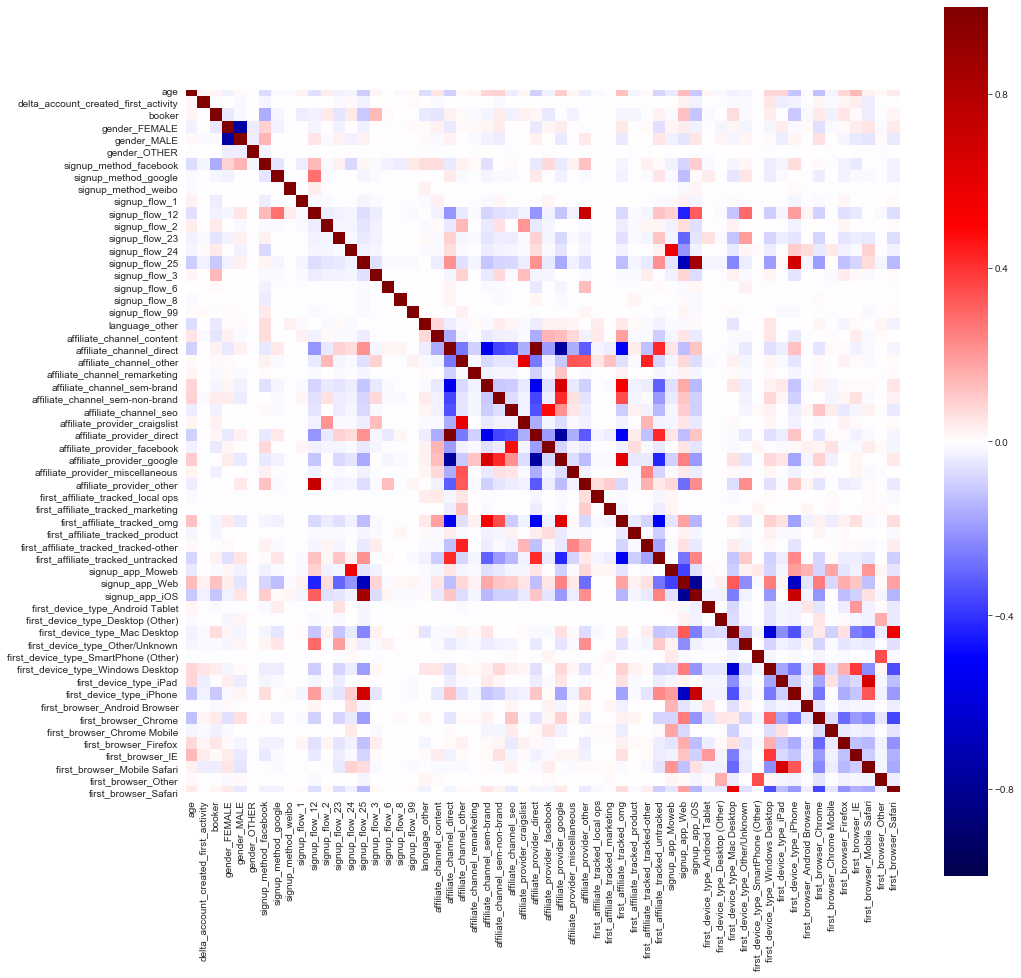

In [17]:
plt.figure(figsize = (16,16));
sns.heatmap(booking_df_dummies.corr(), cmap = 'seismic', vmin = -1, vmax = 1, square = True);

#### Create a helper function to calculate the score of a model

In [13]:
def score(X_train, y_train, X_val, y_val, model, threshold = 0.5):
    
#     print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
#     print("Test set: {:6.2f}%".format(100*model.score(X_val, y_val)))
    
    logit_confusion = confusion_matrix(y_val, model.predict(X_val))
#     print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_val, logit.predict(X_val)), 
#                                                      recall_score(y_val, logit.predict(X_val))))
    
    f1score = f1_score(y_val, model.predict(X_val))
    
    y_train_pred = (model.predict_proba(X_train)[:,1] > threshold)
    y_val_pred = (model.predict_proba(X_val)[:,1] > threshold)

    
    scores = {'Training': [100*model.score(X_train,y_train),precision_score(y_train, y_train_pred),
                         recall_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)],
              
            'Testing': [100*model.score(X_val,y_val),precision_score(y_val, y_val_pred),
                         recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)]}
    
    score_df = pd.DataFrame(scores, index = ['Accuracy', 'Precision', 'Recall', 'F1_Score'])
    
    return score_df

#### Create a helper function to calculate the optimal threshold for the model

In [14]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 
def plot_threshold_curve(X_val, y_val, model, title):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1]);

    plt.figure(dpi=80);
    plt.plot(threshold_curve, precision_curve[1:],label='precision');
    plt.plot(threshold_curve, recall_curve[1:], label='recall');
    plt.legend(loc='lower left');
    plt.xlabel('Threshold (above this probability, label as positive)');
    plt.title(f'Precision and Recall Curves using {title}');
    
    return plt;

#### Create helper function to calculate the ROC and calculate the ROC/AUC score

In [15]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

def plot_ROC(X_val, y_val, model):

    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1]);

    plt.plot(fpr, tpr,lw=6);
    plt.plot([0,1],[0,1],c='violet',ls='--');
    plt.xlim([-0.05,1.05]);
    plt.ylim([-0.05,1.05]);


    plt.xlabel('False positive rate');
    plt.ylabel('True positive rate');
    plt.title('ROC Curve');
    
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    
    return roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

In [16]:
from datetime import datetime

### Logistic Regression

In [17]:
base_logit_adasyn =  LogisticRegression()

In [18]:
base_logit_adasyn.fit(X_adasyn_train, y_adasyn_train)

/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.83      0.59      0.69     22295
           1       0.36      0.65      0.46      7890

    accuracy                           0.60     30185
   macro avg       0.59      0.62      0.58     30185
weighted avg       0.70      0.60      0.63     30185

ROC AUC score =  0.6728196146214305


0.6728196146214305

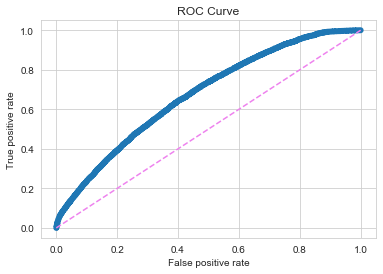

In [19]:
print(classification_report(y_val, base_logit_adasyn.predict(X_val)))
plot_ROC(X_val, y_val,base_logit_adasyn)

In [22]:
logit_adasyn =  LogisticRegression(C=0.9, class_weight='balanced', dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=300,
                    multi_class='warn', n_jobs=1, penalty='l2', random_state=42,
                    solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [23]:
start_time = datetime.now()
logit_adasyn.fit(X_adasyn_train, y_adasyn_train);
logit_training_time = datetime.now() - start_time
print(logit_training_time/X_adasyn_train.shape[0])

0:00:00.000040


#### Logit Model Pickle Checkpoint

In [27]:
pd.to_pickle(logit_adasyn,'logit_model.pkl')

In [28]:
logit_adasyn = pd.read_pickle('logit_model.pkl')

              precision    recall  f1-score   support

           0       0.82      0.61      0.70     22295
           1       0.36      0.63      0.46      7890

    accuracy                           0.61     30185
   macro avg       0.59      0.62      0.58     30185
weighted avg       0.70      0.61      0.64     30185

ROC AUC score =  0.6728465833331201


0.6728465833331201

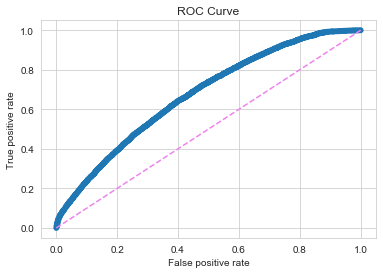

In [29]:
print(classification_report(y_val, logit_adasyn.predict(X_val)))
plot_ROC(X_val, y_val,logit_adasyn)

#### Extract feature coefficients from Logit model

In [30]:
feature_coef_odds = []
for feature in zip(X.columns, np.exp(logit_adasyn.coef_.reshape(-1))):
    feature_coef_odds.append(feature)

feature_odds_coef_df = pd.DataFrame(feature_coef_odds, columns = ['Features', 'Beta'])

In [31]:
top = 5
feature_odds_coef_df = feature_odds_coef_df.set_index('Features')
feature_odds_coef_sorted = feature_odds_coef_df.iloc[(-feature_odds_coef_df['Beta'].abs()).argsort()].head(top)

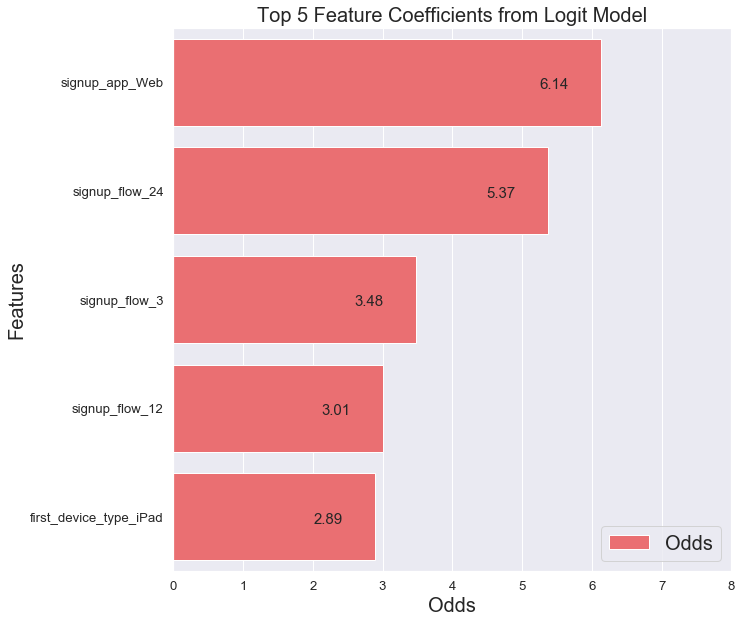

In [111]:
plt.figure(figsize = (10,10));
ax = sns.barplot(y = feature_odds_coef_sorted.index[:top] , x = 'Beta', data = feature_odds_coef_sorted, color = '#FF5A5F', label = 'Odds')
plt.xlim([0,8]);
plt.title(f'Top {top} Feature Coefficients from Logit Model', size = 20);
plt.xlabel('Odds', size = 20);
plt.ylabel('Features', size = 20);
plt.legend(loc = 'lower right', prop={'size': 20});
sns.set(font_scale = 1.2)
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() -1 + p.get_width(), p.get_y() + 0.55),
                xytext=(8, 10), textcoords='offset points', size = 15)
plt.savefig('Logit Model Feature_coef odds.png', bbox_inches = 'tight', dpi = 300)

### Using Knn Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
KNN = KNeighborsClassifier()
KNN_adasyn_clf = KNN.fit(X_adasyn_train, y_adasyn_train)

In [ ]:
print(classification_report(y_val, KNN_adasyn_clf.predict(X_val)))
# plot_ROC(X_adasyn_val, y_adasyn_val, KNN_adasyn_clf)

### Using Naive Bayes Classifer

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

#### MultinomialNB using adasyn 

In [34]:
multiNB_adasyn = MultinomialNB()
multiNB_adasyn_clf = multiNB_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.85      0.39      0.54     22295
           1       0.32      0.80      0.45      7890

    accuracy                           0.50     30185
   macro avg       0.58      0.60      0.50     30185
weighted avg       0.71      0.50      0.52     30185

ROC AUC score =  0.6545724842395906


0.6545724842395906

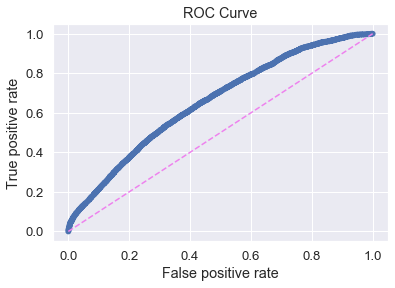

In [35]:
print(classification_report(y_val, multiNB_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, multiNB_adasyn_clf)

#### BernoulliNB using adasyn

In [36]:
bernoulliNB_adasyn = BernoulliNB()
bernoulliNB_adasyn_clf = bernoulliNB_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.85      0.39      0.53     22295
           1       0.32      0.80      0.45      7890

    accuracy                           0.50     30185
   macro avg       0.58      0.59      0.49     30185
weighted avg       0.71      0.50      0.51     30185

ROC AUC score =  0.652795664540834


0.652795664540834

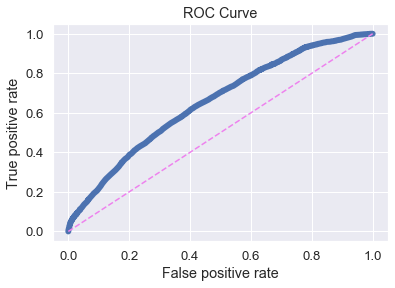

In [37]:
print(classification_report(y_val, bernoulliNB_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, bernoulliNB_adasyn_clf)

#### GaussianNB using adasyn 

In [38]:
gaussianNB_adasyn = GaussianNB()
gaussianNB_adasyn_clf = gaussianNB_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.86      0.30      0.44     22295
           1       0.30      0.86      0.45      7890

    accuracy                           0.45     30185
   macro avg       0.58      0.58      0.45     30185
weighted avg       0.72      0.45      0.44     30185

ROC AUC score =  0.6451720008606794


0.6451720008606794

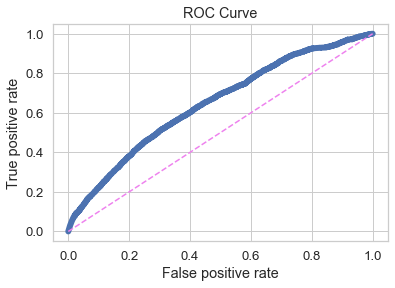

In [154]:
print(classification_report(y_val, gaussianNB_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, gaussianNB_adasyn_clf)

### Using Random Forest Classifer

In [40]:
from sklearn.ensemble import RandomForestClassifier

#### RandomForest using adasyn

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf_adasyn = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=8, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=400,
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False)

In [42]:
state_time = datetime.now()
rf_adasyn_clf = rf_adasyn.fit(X_adasyn_train, y_adasyn_train)
rf_training_time = datetime.now() - start_time
print(rf_training_time/X_adasyn_train.shape[0])

0:00:00.001205


#### RandomForest Pickle Checkpoint

In [44]:
pd.to_pickle(rf_adasyn_clf, 'rf_model.pkl')

In [45]:
rd_adasyn_clf = pd.read_pickle('rf_model.pkl')

              precision    recall  f1-score   support

           0       0.81      0.66      0.73     22295
           1       0.37      0.57      0.45      7890

    accuracy                           0.63     30185
   macro avg       0.59      0.61      0.59     30185
weighted avg       0.70      0.63      0.65     30185

ROC AUC score =  0.667212299870017


0.667212299870017

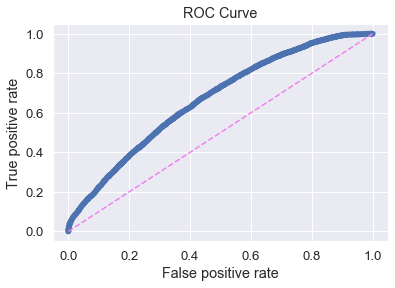

In [46]:
print(classification_report(y_val, rf_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, rf_adasyn_clf)

#### Extract feature importances from RF

In [47]:
feature_importances = []
for feature in zip(X.columns, rf_adasyn_clf.feature_importances_):
    feature_importances.append(feature)
    
feature_importance_df = pd.DataFrame(feature_importances, columns = ['Features', 'Importance'])

In [48]:
# Show the top most important features
feature_importance_df.set_index('Features').sort_values(by = 'Importance', ascending = False).head(10)

,Importance
Features,
signup_method_facebook,0.302237
first_affiliate_tracked_untracked,0.085390
signup_flow_3,0.075040
gender_FEMALE,0.067099
signup_app_Web,0.059834
gender_MALE,0.036562
signup_app_iOS,0.036153
first_device_type_iPhone,0.035585
language_other,0.029576


### Using XGBoost Classifer

In [49]:
from xgboost import XGBClassifier

In [50]:
xgb_param = {'colsample_bytree': 0.5, 'gamma': 8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}
XGBoost_adasyn = XGBClassifier(random_state = 101, **xgb_param, n_jobs = -1 )

In [51]:
state_time = datetime.now()
XGBoost_adasyn_clf = XGBoost_adasyn.fit(X_adasyn_train, y_adasyn_train)
XGBoost_training_time = datetime.now() - start_time
print(XGBoost_training_time/X_adasyn_train.shape[0])

0:00:00.002172


#### XGBoost Pickle Checkpoint

In [52]:
pd.to_pickle(XGBoost_adasyn_clf, 'XGB_model.pkl')

In [303]:
XGBoost_adasyn_clf = pd.read_pickle('XGB_model.pkl')

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     22295
           1       0.55      0.11      0.19      7890

    accuracy                           0.74     30185
   macro avg       0.65      0.54      0.52     30185
weighted avg       0.70      0.74      0.68     30185

ROC AUC score =  0.6784802414677483


0.6784802414677483

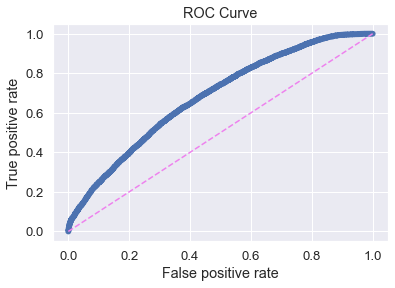

In [54]:
print(classification_report(y_val, XGBoost_adasyn_clf.predict(X_val.values)))
plot_ROC(X_val.values, y_val, XGBoost_adasyn_clf)

### Using LGBM Classifer

In [55]:
import lightgbm as lgb

/Users/bentleyou/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [56]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_sample=300, min_child_samples=20,
                min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
                n_jobs=-1, num_leaves=50, objective=None, random_state=90,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.6,
                subsample_for_bin=200000, subsample_freq=0);

In [57]:
state_time = datetime.now()
lgb_model.fit(X_adasyn_train, y_adasyn_train, eval_metric='auc',  
                  eval_set=[(X_val, y_val)], 
                  verbose=False, early_stopping_rounds=300)
lgb_training_time = datetime.now() - start_time
print(lgb_training_time/X_adasyn_train.shape[0])

0:00:00.003200


              precision    recall  f1-score   support

           0       0.76      0.97      0.85     22295
           1       0.55      0.12      0.20      7890

    accuracy                           0.74     30185
   macro avg       0.65      0.54      0.52     30185
weighted avg       0.70      0.74      0.68     30185

ROC AUC score =  0.6777076765607843


0.6777076765607843

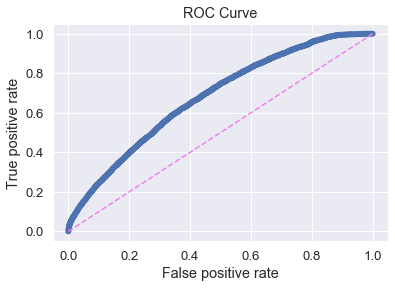

In [58]:
print(classification_report(y_val, lgb_model.predict(X_val.values)))
plot_ROC(X_val.values, y_val, lgb_model)

### Using Decision Trees Classifer

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
dt_adasyn = DecisionTreeClassifier(random_state= 42, max_features='sqrt')
dt_adasyn_clf = dt_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77     22295
           1       0.33      0.30      0.32      7890

    accuracy                           0.66     30185
   macro avg       0.55      0.54      0.55     30185
weighted avg       0.65      0.66      0.65     30185

ROC AUC score =  0.5552955316585331


0.5552955316585331

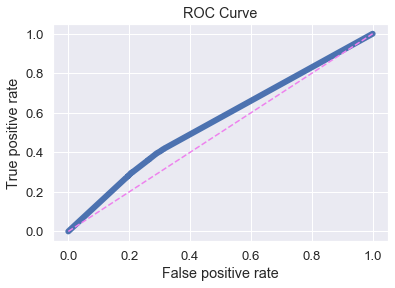

In [61]:
print(classification_report(y_val, dt_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, dt_adasyn_clf)

### Using Catboost Classifer

In [65]:
from catboost import CatBoostClassifier

booking_df_cat = booking_df.copy()
X_catboost = booking_df_cat.drop('booker', 1)
y_catboost = booking_df_cat.booker

X_catboost, X_test_catboost, y_catboost, y_test_catboost = train_test_split(X_catboost, y_catboost, test_size=0.20, random_state=42, stratify = y_catboost)
X_train_catboost, X_val_catboost, y_train_catboost, y_val_catboost = train_test_split(X_catboost, y_catboost, test_size=0.25, random_state=42, stratify = y_catboost)

booking_features = list(X_train_catboost.drop(['age', 'delta_account_created_first_activity'], 1).columns)

In [66]:
catboost_clf = CatBoostClassifier(iterations=500,l2_leaf_reg=6, loss_function='Logloss', 
                                     cat_features=booking_features, learning_rate=0.1, 
                                     depth= 4, random_state = 69, verbose = False)

In [296]:
start_time = datetime.now()
catboost_clf = catboost_clf.fit(X_train_catboost, y_train_catboost);
catboost_training_time = datetime.now() - start_time
print(catboost_training_time/X_train_catboost.shape[0])

0:00:00.000180


              precision    recall  f1-score   support

           0       0.75      0.98      0.85     22295
           1       0.62      0.07      0.13      7890

    accuracy                           0.75     30185
   macro avg       0.68      0.53      0.49     30185
weighted avg       0.72      0.75      0.66     30185

ROC AUC score =  0.6817484070467698


0.6817484070467698

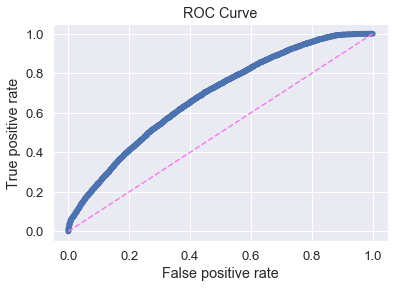

In [73]:
print(classification_report(y_val_catboost, catboost_clf.predict(X_val_catboost)))
plot_ROC(X_val_catboost, y_val_catboost, catboost_adasyn_clf)

#### Catboost Pickle Checkpoint

In [68]:
pd.to_pickle(catboost_clf, 'catboost_clf.pkl')

In [69]:
catboost_clf = pd.read_pickle('catboost_clf.pkl')

In [70]:
feature_importances = []
for feature in zip(X_train_catboost.columns, catboost_clf.feature_importances_):
    feature_importances.append(feature)
    
feature_importance_df = pd.DataFrame(feature_importances, columns = ['Features', 'Importance'])

In [71]:
top5_features_importance = feature_importance_df.sort_values(by = 'Importance', ascending = False).head(5)

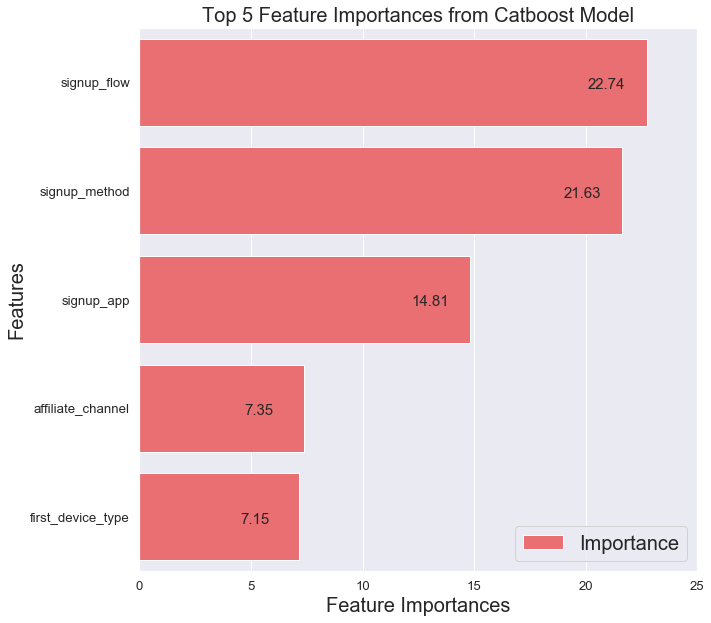

In [106]:
plt.figure(figsize = (10,10));
ax = sns.barplot(y = top5_features_importance.Features, x = top5_features_importance.Importance, 
            data = top5_features_importance, color = '#FF5A5F', label = 'Importance')
plt.xlim([0,25]);
plt.title(f'Top {top} Feature Importances from Catboost Model', size = 20);
plt.xlabel('Feature Importances', size = 20);
plt.ylabel('Features', size = 20);
plt.legend(loc = 'lower right', prop={'size': 20});
sns.set(font_scale = 1.2)
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() - 3 + p.get_width(), p.get_y() + 0.55),
                xytext=(8, 10), textcoords='offset points', size = 15)
plt.savefig('Catboost_Feature_Importance.png', bbox_inches = 'tight', dpi = 300)

In [147]:
target_names = list(booking_df['booker'].unique())
target_names

[1, 0]

In [148]:
catboost_clf.target_names = target_name

In [151]:
catboost_clf.target_names

[1, 0]

In [142]:
# lr_model.feature_names = iris_data.feature_names
catboost_clf.target_names = booking_df.booker.unique()

In [152]:
pd.to_pickle(catboost_clf, 'catboost_clf.pkl')

In [138]:
catboost_clf = pd.read_pickle('catboost_clf.pkl')

#### Training Time

In [194]:
size = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
logit_training_size = []
logit_training_time = []
for s in size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=s, random_state=40, stratify = y)
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=41).fit_sample(X_train,y_train)
    start = datetime.now()
    logit_adasyn.fit(X_adasyn_train, y_adasyn_train)
    time = datetime.now() - start
    logit_training_time.append(time)
    logit_training_size.append(len(X_train))

In [195]:
logit_training_time = [(x.seconds * 1e6 + x.microseconds) for x in logit_training_time]

In [196]:
logit_training_size

[24147, 36221, 48294, 60368, 72442, 84515, 96589, 108663]

In [297]:
training_time

[datetime.timedelta(microseconds=943178),
 datetime.timedelta(seconds=1, microseconds=623635),
 datetime.timedelta(seconds=2, microseconds=642180),
 datetime.timedelta(seconds=3, microseconds=363735),
 datetime.timedelta(seconds=4, microseconds=153603),
 datetime.timedelta(seconds=5, microseconds=379791),
 datetime.timedelta(seconds=6, microseconds=7565),
 datetime.timedelta(seconds=7, microseconds=280462),
 datetime.timedelta(seconds=1, microseconds=744840),
 datetime.timedelta(seconds=3, microseconds=272163),
 datetime.timedelta(seconds=5, microseconds=309234),
 datetime.timedelta(seconds=7, microseconds=375745),
 datetime.timedelta(seconds=9, microseconds=735935),
 datetime.timedelta(seconds=11, microseconds=708768),
 datetime.timedelta(seconds=13, microseconds=744974),
 datetime.timedelta(seconds=16, microseconds=212380)]

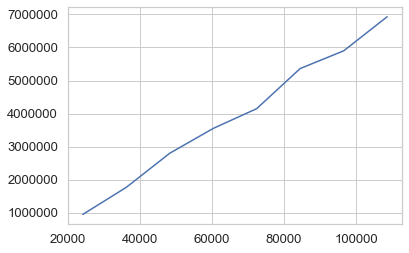

In [198]:
plt.plot(logit_training_size, logit_training_time)

In [304]:
size = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
xgb_training_size = []
xgb_training_time = []
for s in size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=s, random_state=40, stratify = y)
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=41).fit_sample(X_train,y_train)
    start = datetime.now()
    XGBoost_adasyn_clf.fit(X_adasyn_train, y_adasyn_train)
    time = datetime.now() - start
    xgb_training_time.append(time)
    xgb_training_size.append(len(X_train))

In [308]:
xgb_training_time = [(x.seconds * 1e6 + x.microseconds) for x in xgb_training_time]

In [201]:
size = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
cat_training_size = []
cat_training_time = []
for s in size:
    X_catboost_train, X_test_catboost, y_catboost_train, y_test_catboost = train_test_split(X_catboost, y_catboost, test_size=s, random_state=40, stratify = y_catboost)
    start = datetime.now()
    catboost_clf.fit(X_catboost_train, y_catboost_train)
    time = datetime.now() - start
    cat_training_time.append(time)
    cat_training_size.append(len(X_catboost_train))

In [202]:
cat_training_time = [(x.seconds * 1e6 + x.microseconds) for x in cat_training_time]

#### Plotting training time versus n training examples

In [210]:
len(cat_training_size), len(cat_training_time)

(8, 8)

In [209]:
len(rf_training_size), len(training_time)

(0, 16)

In [207]:
len(logit_training_size), len(logit_training_time)

(8, 8)

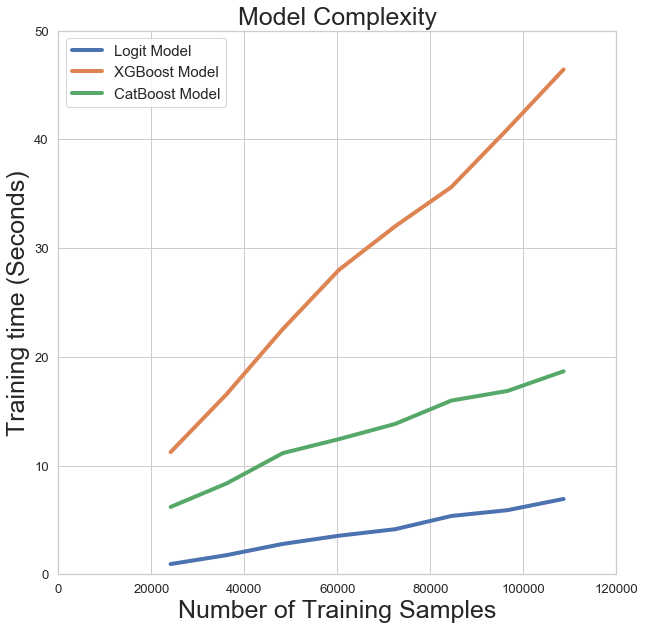

In [310]:
plt.figure(figsize = (10,10))
sns.lineplot(logit_training_size, np.array(logit_training_time)/1e6, lw = 4, label = 'Logit Model')
sns.lineplot(xgb_training_size, np.array(xgb_training_time)/1e6, lw = 4, label = 'XGBoost Model')
sns.lineplot(cat_training_size, np.array(cat_training_time)/1e6, lw = 4, label = 'CatBoost Model')
plt.title('Model Complexity', size = 25);
plt.xlabel('Number of Training Samples', size = 25);
plt.ylabel('Training time (Seconds)', size = 25);
plt.legend(loc = 'upper left', prop={'size': 15});

plt.xlim([0,120000]);
plt.ylim([0,50]);
plt.savefig('Model Complexity.png', bbox_inches = 'tight', dpi = 300)

In [203]:
import timeit # We'll use this package to run each simulation multiple times and take the fastest runtime 

num_loops = 5
num_repeats = 1
num_tests = 20
max_samples = 1500
max_features = 100
max_sec = 30

# my favorite way to build a datafrom on the fly is 
# to start with a list of dictionaries
complexity_lod = []


# Each time we run our algorithm, we'll want to use a larger sample size to test the effect of sample size on runtime
# Set up the list of sample sizes we'll use
samples = np.linspace(50,max_samples, num=num_tests, dtype=int)

# We'll want to test multiple algorithms 
model_dict = {

    "logistic": LogisticRegression(C=0.9, class_weight='balanced', dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=300,
                    multi_class='warn', n_jobs=1, penalty='l2', random_state=42,
                    solver='newton-cg', tol=0.0001, verbose=0, warm_start=False),
    
}


# Run all of our models, increasing the sample size each time (from samples list we made above)
for n_samp in samples:
    print(f"Running for {n_samp} samples. ", end="")
    lap_time = arrow.now()
    
    # Loop through each algorithm 
    for model_key in model_dict:
        
        model = model_dict[model_key]
    
        # we take the min of the repeats because variation is likely due not to python execution 
        # but other operations https://docs.python.org/3/library/timeit.html#timeit.Timer.repeat
        train_time = np.min(
            timeit.repeat(
                f'model.fit(x[:n_samp,:max_features],y[:n_samp])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        test_time = np.min(
            timeit.repeat(
                f'model.predict(x[:n_samp,:max_features])',
                globals=globals(),
                repeat=num_repeats,
                number=num_loops))

        complexity_lod.append({
                "model": model_key,
                "train_time": train_time,
                "test_time": test_time,
                "n_samples": n_samp
            })
    print(f"Time: {(arrow.now() -lap_time).seconds} seconds.")
    if lap_time.shift(seconds=max_sec) < arrow.now():
        print("breaking")
        break
        
complexity_df = pd.DataFrame(complexity_lod)

Running for 50 samples. 

NameError: name 'arrow' is not defined

### ROC AUC Between Models

In [74]:
models = [bernoulliNB_adasyn_clf, multiNB_adasyn_clf, logit_adasyn, gaussianNB_adasyn_clf,
          rf_adasyn_clf, dt_adasyn_clf]
labels = ['BernoulliNB_adasyn','MultiNB_adasyn', 'Logistic_Regression_adasyn', 
          'GaussianNB_adasyn',  'RandomForest_adasyn', 'DecisionTree_adasyn']
AUCs = []

lw = 3;

for model in models:
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    AUCs.append(round(auc,3))

In [75]:
model_graph = []
for element in zip(models, labels, AUCs):
    
    model_graph.append(element)
    
model_graph = sorted(model_graph, key=lambda tup: tup[2], reverse = True);

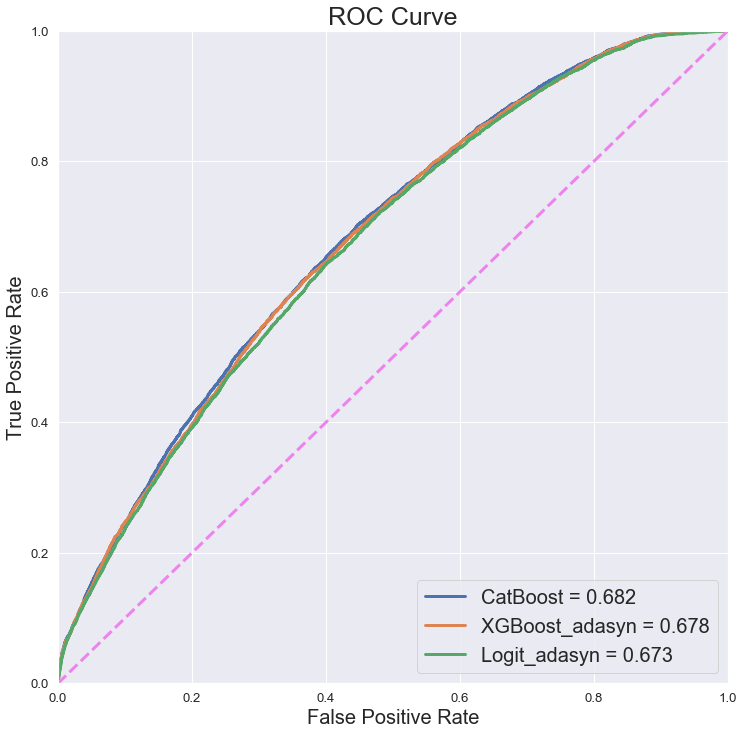

In [105]:
plt.figure(figsize = (12,12))

fpr_cat_adasyn, tpr_cat_adasyn, thresholds_cat_adasyn = roc_curve(y_val_catboost, catboost_adasyn_clf.predict_proba(X_val_catboost)[:,1])
auc_cat_adasyn = roc_auc_score(y_val_catboost, catboost_clf.predict_proba(X_val_catboost)[:,1])
plt.plot(fpr_cat_adasyn, tpr_cat_adasyn,lw=lw, label = 'CatBoost' + f' = {round(auc_cat_adasyn,3)}')

fpr_xgb_adasyn, tpr_xgb_adasyn, thresholds_xgb_adasyn = roc_curve(y_val, XGBoost_adasyn_clf.predict_proba(X_val.values)[:,1])
auc_xgb_adasyn = roc_auc_score(y_val, XGBoost_adasyn_clf.predict_proba(X_val.values)[:,1])
plt.plot(fpr_xgb_adasyn, tpr_xgb_adasyn,lw=lw, label = 'XGBoost_adasyn' + f' = {round(auc_xgb_adasyn,3)}')

fpr_logit_adasyn, tpr_logit_adasyn, thresholds_logit_adasyn = roc_curve(y_val, logit_adasyn.predict_proba(X_val)[:,1])
auc_logit_adasyn = roc_auc_score(y_val, logit_adasyn.predict_proba(X_val)[:,1])
plt.plot(fpr_logit_adasyn, tpr_logit_adasyn,lw=lw, label = 'Logit_adasyn' + f' = {round(auc_logit_adasyn,3)}')

for model in zip(model_graph):

    fpr, tpr, thresholds = roc_curve(y_val, model[0][0].predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr,lw=lw, label = model[0][1] + f' = {model[0][2]}')
        
plt.plot([0,1],[0,1],c='violet',ls='--', lw=lw);
plt.xlim([0,1.00]);
plt.ylim([0,1.00]);
plt.xlabel('False Positive Rate', size = 20);
plt.ylabel('True Positive Rate', size = 20);
plt.title('ROC Curve', size = 25);
plt.legend(loc = 'lower right', prop={'size': 20});
plt.savefig('Top 3 ROC Curve.png', bbox_inches = 'tight', dpi = 300)

#### Testing

In [ ]:
X_test = X_test
y_test = y_test
model = logit_adasyn

              precision    recall  f1-score   support

           0       0.97      0.06      0.11      8918
           1       0.27      0.99      0.43      3156

    accuracy                           0.30     12074
   macro avg       0.62      0.53      0.27     12074
weighted avg       0.79      0.30      0.19     12074



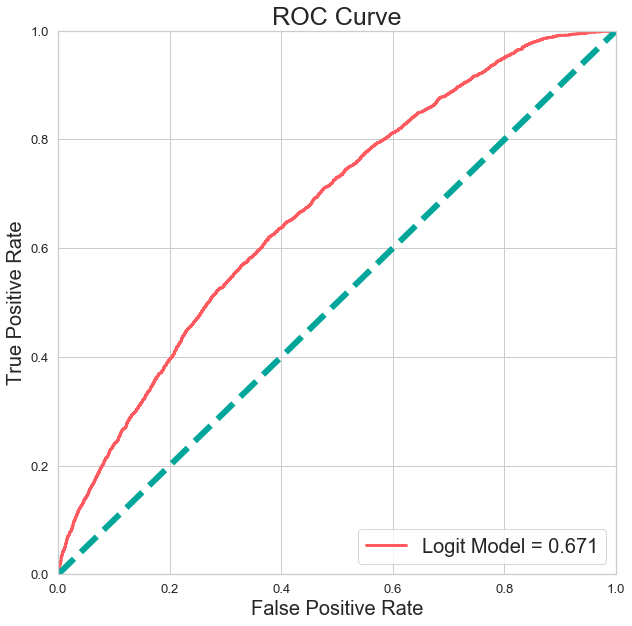

In [235]:
print(classification_report(y_test, model.predict_proba(X_test)[:,1] > 0.16))
plt.figure(figsize = (10, 10));
fpr_model, tpr_model, thresholds_model = roc_curve(y_test, model.predict_proba(X_test)[:,1])
auc_model = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr_cat_adasyn, tpr_cat_adasyn,lw=lw, label = 'Logit Model' + f' = {round(auc_model,3)}', c='#FF5A5F')
plt.plot([0,1],[0,1],c='#00A699',ls='--', lw=6);
plt.xlim([0,1.00]);
plt.ylim([0,1.00]);
plt.xlabel('False Positive Rate', size = 20);
plt.ylabel('True Positive Rate', size = 20);
plt.title('ROC Curve', size = 25);
plt.legend(loc = 'lower right', prop={'size': 20});
plt.savefig('Logit ROC Curve.png', boxx_inches = 'tight', dpi = 300)

In [79]:
# Percent of user who will make a booking
percent_booker = (booking_df[booking_df['booker'] == 1].shape[0])/(booking_df.shape[0])
print(f'{round(percent_booker,2)} will make a booking')


# By 2020, airbnb will have 3 million new users

num_new_bookers = round(3e6 * percent_booker)
print(f'There is a total of roughly 3 million new users on airbnb in 2020.')
print(f'There is {num_new_bookers} potential new bookers in 2020')


# Average daily booking is $160.47 and airbnb roughly profits 20% from the booking price.
revenue_per_booker = round(0.2 * 160.47)

print(f'On average, the daily booking is $160.47 and airbnb roughly takes 20% from the booking price')
print(f'Roughly, there is $32 of revenue per user')


# Total potential profit = num_new_booker * profit_per_booker
total_revenue = num_new_bookers * revenue_per_booker
# print(f'There is an estimated total of ${round(total_revenue)} in profit available in 2020 from {round(num_new_bookers)} new users with an estimated profit of ${revenue_per_booker} per new user!')

# Cost of advertising

cost_advertisement_per_user = 5

cost_of_total_advertisement = num_new_bookers * 5

# print(cost_of_total_advertisement)

Cost_TP = cost_advertisement_per_user 
Cost_TN = 0
Cost_FP = cost_advertisement_per_user
Cost_FN = 0
      
Revenue_TP = revenue_per_booker
Revenue_TN = 0
Revenue_FP = 0
Revenue_FN = 0

print('\n')
print(f'The cost for True Postives: ${-Cost_TP}')
print(f'The cost for True Negatives: ${-Cost_TN}')
print(f'The cost for False Postives: ${-Cost_FP}')
print(f'The cost for False Negative: ${-Cost_FN}')
print('\n')
print(f'The revenue for True Postives: ${Revenue_TP}')
print(f'The revenue for True Negatives: ${Revenue_TN}')
print(f'The revenue for False Postives: ${Revenue_FP}')
print(f'The revenue for False Negative: ${Revenue_FN}')

0.26 will make a booking
There is a total of roughly 3 million new users on airbnb in 2020.
There is 784220 potential new bookers in 2020
On average, the daily booking is $160.47 and airbnb roughly takes 20% from the booking price
Roughly, there is $32 of revenue per user


The cost for True Postives: $-5
The cost for True Negatives: $0
The cost for False Postives: $-5
The cost for False Negative: $0


The revenue for True Postives: $32
The revenue for True Negatives: $0
The revenue for False Postives: $0
The revenue for False Negative: $0


#### Economics

In [247]:
Cost_TP = cost_advertisement_per_user 
Cost_TN = 0
Cost_FP = cost_advertisement_per_user
Cost_FN = 0
      
Revenue_TP = revenue_per_booker
Revenue_TN = 0
Revenue_FP = 0
Revenue_FN = 0

Total_revenue_cat = []

for threshold in np.linspace(0,1,26):
    TN = confusion_matrix(y_test_catboost, catboost_adasyn_clf.predict_proba(X_test_catboost)[:,1] > threshold)[0][0]
    TP = confusion_matrix(y_test_catboost, catboost_adasyn_clf.predict_proba(X_test_catboost)[:,1] > threshold)[1][1]
    FN = confusion_matrix(y_test_catboost, catboost_adasyn_clf.predict_proba(X_test_catboost)[:,1] > threshold)[1][0]
    FP = confusion_matrix(y_test_catboost, catboost_adasyn_clf.predict_proba(X_test_catboost)[:,1] > threshold)[0][1]
    
    num_test_users = len(X_test_catboost)
    
    # Total = Fraction of users for (TP, TN, FP, FN) * total users * Revenue per users
    
    Total = ((TP/num_test_users) * 3e6 * (Revenue_TP - Cost_TP) + 
             (TN/num_test_users) * 3e6 * (Revenue_TN - Cost_TN) + 
             (FP/num_test_users) * 3e6 * (Revenue_FP - Cost_FP) + 
             (FN/num_test_users) * 3e6 * (Revenue_FN - Cost_FN))
    
    Total_revenue_cat.append(Total/1e6)

In [264]:
Cost_TP = cost_advertisement_per_user 
Cost_TN = 0
Cost_FP = cost_advertisement_per_user
Cost_FN = 0
      
Revenue_TP = revenue_per_booker
Revenue_TN = 0
Revenue_FP = 0
Revenue_FN = 0

y_test = y_test
X_test = X_test
model = logit_adasyn
Total_revenue_logit = []

for threshold in np.linspace(0,1,26):

    TN = confusion_matrix(y_test, model.predict_proba(X_test)[:,1] > threshold)[0][0]
    TP = confusion_matrix(y_test, model.predict_proba(X_test)[:,1] > threshold)[1][1]
    FN = confusion_matrix(y_test, model.predict_proba(X_test)[:,1] > threshold)[1][0]
    FP = confusion_matrix(y_test, model.predict_proba(X_test)[:,1] > threshold)[0][1]
    
    num_test_users = len(X_test)
    
    # Total = Fraction of users for (TP, TN, FP, FN) * total users * Revenue per users
    
    Total = ((TP/num_test_users) * 3e6 * (Revenue_TP - Cost_TP) + 
             (TN/num_test_users) * 3e6 * (Revenue_TN - Cost_TN) + 
             (FP/num_test_users) * 3e6 * (Revenue_FP - Cost_FP) + 
             (FN/num_test_users) * 3e6 * (Revenue_FN - Cost_FN))
    
    Total_revenue_logit.append(Total/1e6)

In [291]:
Cost_TP = cost_advertisement_per_user 
Cost_TN = 0
Cost_FP = cost_advertisement_per_user
Cost_FN = 0
      
Revenue_TP = revenue_per_booker
Revenue_TN = 0
Revenue_FP = 0
Revenue_FN = 0

y_test = y_val
X_test = X_val
model = XGBoost_adasyn_clf
Total_revenue_xgb = []

for threshold in np.linspace(0,1,26):

    TN = confusion_matrix(y_test, model.predict_proba(X_test.values)[:,1] > threshold)[0][0]
    TP = confusion_matrix(y_test, model.predict_proba(X_test.values)[:,1] > threshold)[1][1]
    FN = confusion_matrix(y_test, model.predict_proba(X_test.values)[:,1] > threshold)[1][0]
    FP = confusion_matrix(y_test, model.predict_proba(X_test.values)[:,1] > threshold)[0][1]
    
    num_test_users = len(X_test)
    
    # Total = Fraction of users for (TP, TN, FP, FN) * total users * Revenue per users
    
    Total = ((TP/num_test_users) * 3e6 * (Revenue_TP - Cost_TP) + 
             (TN/num_test_users) * 3e6 * (Revenue_TN - Cost_TN) + 
             (FP/num_test_users) * 3e6 * (Revenue_FP - Cost_FP) + 
             (FN/num_test_users) * 3e6 * (Revenue_FN - Cost_FN))
    
    Total_revenue_xgb.append(Total/1e6)

In [292]:
# maximum revenue from this model in millions
max(Total_revenue_cat), max(Total_revenue_xgb), max(Total_revenue_logit)

(11.452128540665896, 11.400993871128042, 11.309011098227595)

In [290]:
# Optimal probability threshold to yield highest revenue
np.linspace(0,1,26)[4]

0.16

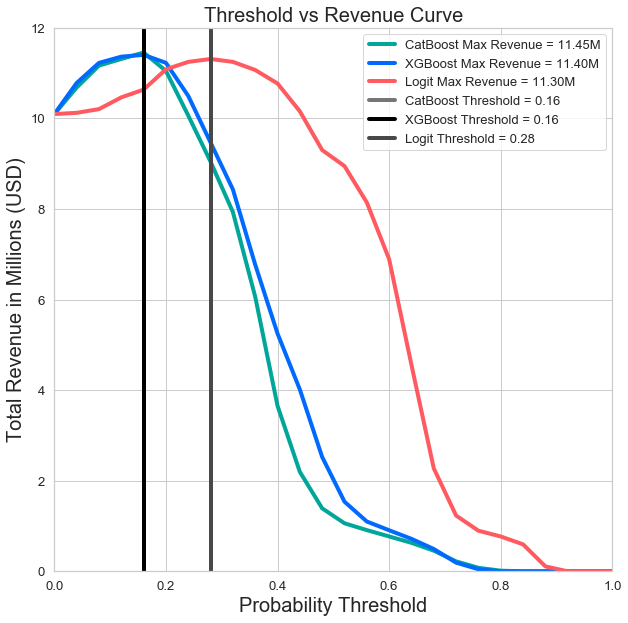

In [295]:
plt.figure(figsize = (10,10));
lw = 4
sns.lineplot(np.linspace(0,1,26), Total_revenue_cat, lw = 4, label = 'CatBoost Max Revenue = 11.45M', color = '#00A699');
sns.lineplot(np.linspace(0,1,26), Total_revenue_xgb, lw = 4, label = 'XGBoost Max Revenue = 11.40M', color = '#006AFF');
sns.lineplot(np.linspace(0,1,26), Total_revenue_logit, lw = 4, label = 'Logit Max Revenue = 11.30M', color = '#FF5A5F');


plt.plot(100*[0.16], np.linspace(0,15,100), color='#767676', lw = 4, label = 'CatBoost Threshold = 0.16')
plt.plot(100*[0.16], np.linspace(0,15,100), color='#000000', lw = 4, label = 'XGBoost Threshold = 0.16')
plt.plot(100*[0.28], np.linspace(0,15,100), color='#484848', lw = 4, label = 'Logit Threshold = 0.28')


plt.xlabel('Probability Threshold', size = 20);
plt.ylabel('Total Revenue in Millions (USD)', size = 20);
plt.title('Threshold vs Revenue Curve', size = 20);
plt.xlim([0,1]);
plt.ylim([0, 12]);
plt.legend(loc = 'upper right', prop={'size': 13});
plt.savefig('Threshold Vs Revenue Comparison', bbox_inches = 'tight', dpi = 300)

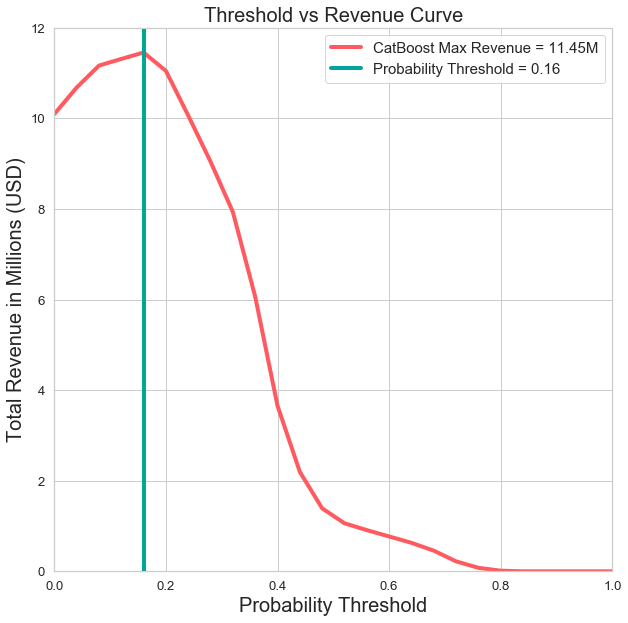

In [262]:
plt.figure(figsize = (10,10));
lw = 6
# sns.lineplot(np.linspace(0,1,26), Total_revenue_logit, lw = 4, label = 'Logit Max Revenue = 11.30M', color = '');
sns.lineplot(np.linspace(0,1,26), Total_revenue_cat, lw = 4, label = 'CatBoost Max Revenue = 11.45M', color = '#FF5A5F');

# plt.plot(100*[0.28], np.linspace(0,15,100), color='', lw = 4, label = 'Probability Threshold = 0.28')
plt.plot(100*[0.16], np.linspace(0,15,100), color='#00A699', lw = 4, label = 'Probability Threshold = 0.16')
plt.xlabel('Probability Threshold', size = 20);
plt.ylabel('Total Revenue in Millions (USD)', size = 20);
plt.title('Threshold vs Revenue Curve', size = 20);
plt.xlim([0,1]);
plt.ylim([0, 12]);
plt.legend(loc = 'upper right', prop={'size': 15});
plt.savefig('Threshold Vs Revenue', bbox_inches = 'tight', dpi = 300)